In [148]:
with open("seed.txt", "r") as f:
    seed = int(f.read().strip())

print(f"seed = {seed}")

seed = 52772


In [149]:
#Task 1: Regression — Regularization on Housing Data
#1.1 1A. Data Preprocessing (Required)
#1. Use your seed to create a 60/20/20 train/validation/test split.

#load dataset
import urllib.request
import pandas as pd
import numpy as np

url = "https://lib.stat.cmu.edu/datasets/boston"
response = urllib.request.urlopen(url)
raw = response.read().decode()
lines = raw.strip().splitlines()
data_lines = lines[22:] #dataset starts from line 23 

dataset = []

#each data contains 2 lines
for i in range(0, len(data_lines), 2):
    line1 = data_lines[i].strip().split()
    line2 = data_lines[i+1].strip().split()
    dataset.append(line1 + line2)

column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM",
    "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

df = pd.DataFrame(dataset, columns=column_names).astype(float)

display(df)

total_rows = len(df)
print(f"Total rows in dataset: {total_rows}")

np.random.seed(seed)
indices = np.random.permutation(total_rows)

train_end = int(0.6 * total_rows)
validation_end = int(0.8 * total_rows)

train_index = indices[:train_end] #60%
validation_index   = indices[train_end:validation_end] #20%
test_index  = indices[validation_end:] #20%

train_df = df.iloc[train_index]
validation_df   = df.iloc[validation_index]
test_df  = df.iloc[test_index]

#verify split correctly
print(f"Train set: {len(train_df)} rows,", f"Validation set: {len(validation_df)} rows,", f"Test set: {len(test_df)}")
print(f"Train: {len(train_df)/len(df)*100:.1f}%, ", f"Validation: {len(validation_df)/len(df)*100:.1f}%, ", f"Test: {len(test_df)/len(df)*100:.1f}%")


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Total rows in dataset: 506
Train set: 303 rows, Validation set: 101 rows, Test set: 102
Train: 59.9%,  Validation: 20.0%,  Test: 20.2%


In [150]:
#2. Handle missing values (if any) and apply appropriate transformations:
#• If categorical columns exist: apply one-hot encoding.

error_num = df.isnull().sum()
print("Missing values: ")
print(error_num)
#So there is no missing values in this dataset

categorical_columns = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print(f"categorical_columns: {categorical_columns}" )
#categorical_columns is empty, so there is no categorical columns in this dataset


#• Create two interaction features of your choice; justify why they may help.

# RM(average number of rooms per dwelling)and LSTAT(% lower status of the population) are two interaction features. 
# In a high-status neighborhood, where LSTAT is low, an extra room can add a lot of value. However, in a low-status area,
# where LSTAT is high, an extra room may only add little value. So in the model, we want to show that the effect of room 
# numbers depends on the LSTAT. Adding the interaction RM × LSTAT to capture non-additive effects between house size and 
# neighborhood socioeconomic status can improve model expressiveness. 



Missing values: 
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
categorical_columns: []


In [151]:
#3. Run the full pipeline under three scaling settings:

X_train = train_df.to_numpy(dtype=float)
X_val = validation_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)

#(a) No scaling
train_no_scale, validation_no_scale, test_no_scale = X_train, X_val, X_test

#(b) Standard scaling (z-score)
def standard_scaler_fit(X_train):
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0  # signma cannot be zero
    return mu, sigma

def standard_scaler_transform(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = standard_scaler_fit(X_train)

train_standard_scaling = standard_scaler_transform(X_train, mu, sigma)
validation_standard_scaling = standard_scaler_transform(X_val, mu, sigma)
test_standard_scaling = standard_scaler_transform(X_test, mu, sigma)

#(c) Robust scaling (median/IQR)
def robust_scaler_fit(X_train):
    median = np.median(X_train, axis=0)
    q1 = np.percentile(X_train, 25, axis=0)
    q3 = np.percentile(X_train, 75, axis =0)
    iqr =  q3 - q1
    iqr[iqr == 0] = 1 # iqr cannot be zero
    return median, iqr

def robust_scaler_transform(X, median, iqr):
    return (X-median) / iqr

median, iqr = robust_scaler_fit(X_train)

train_robust_scaling = robust_scaler_transform(X_train, median, iqr)
validation_robust_scaling = robust_scaler_transform(X_val, median, iqr)
test_robust_scaling = robust_scaler_transform(X_test, median, iqr)

print("Dimension of dataframe: ")
print("No Scaling: ", train_no_scale.shape, validation_no_scale.shape, test_no_scale.shape)
print("Standard Scaling: ", train_standard_scaling.shape, validation_standard_scaling.shape, test_standard_scaling.shape)
print("Robust Scaling: ", train_robust_scaling.shape, validation_robust_scaling.shape, test_robust_scaling.shape)


Dimension of dataframe: 
No Scaling:  (303, 14) (101, 14) (102, 14)
Standard Scaling:  (303, 14) (101, 14) (102, 14)
Robust Scaling:  (303, 14) (101, 14) (102, 14)


Condition number κ(X^T X):
  Before scaling (no scaling):  7.2887e+07
  After standard scaling:       1.2544e+02
  After robust scaling:         2.3851e+03
Top 10 correlation features:
('RAD', 'TAX', 0.93)
('INDUS', 'NOX', 0.77)
('NOX', 'DIS', 0.77)
('LSTAT', 'MEDV', 0.74)
('NOX', 'AGE', 0.73)
('AGE', 'DIS', 0.73)
('INDUS', 'TAX', 0.7)
('INDUS', 'DIS', 0.69)
('NOX', 'TAX', 0.67)
('ZN', 'DIS', 0.65)


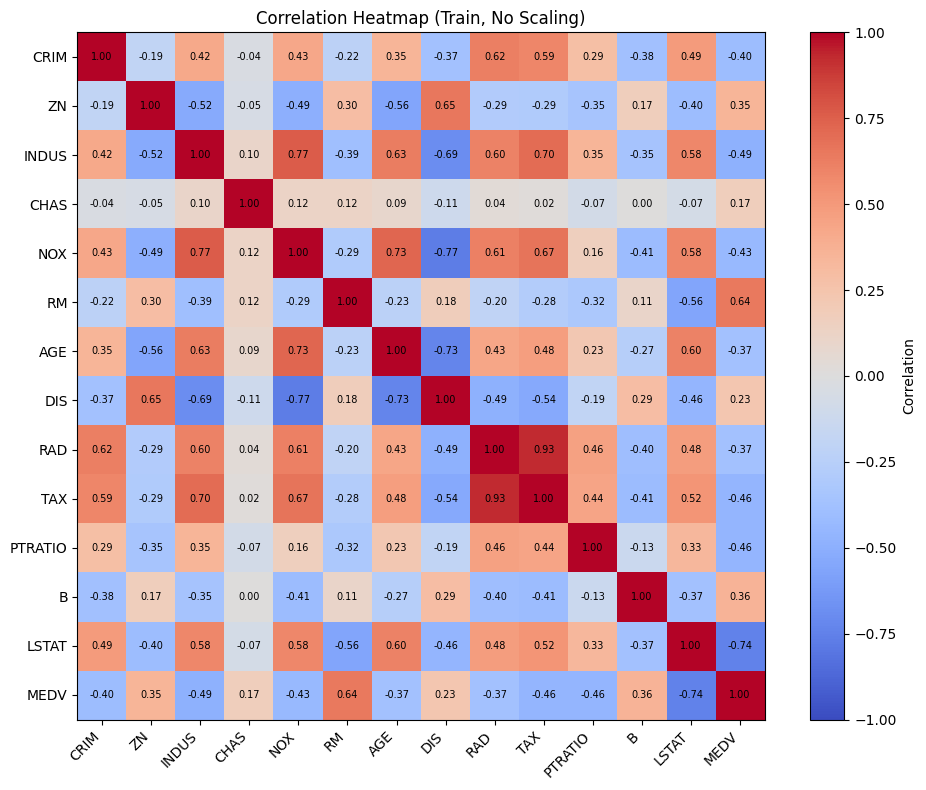

In [152]:
#4. Compute and report:
#• Condition number κ(X⊤X) (np.linalg.cond(XtX)) before and after scaling

def condition_number(X):
    """Compute κ(X^T X) for design matrix X."""
    XtX = X.T @ X
    return np.linalg.cond(XtX)

kappa_no_scale = condition_number(train_no_scale)
kappa_standard = condition_number(train_standard_scaling)
kappa_robust = condition_number(train_robust_scaling)

print("Condition number κ(X^T X):")
print(f"  Before scaling (no scaling):  {kappa_no_scale:.4e}")
print(f"  After standard scaling:       {kappa_standard:.4e}")
print(f"  After robust scaling:         {kappa_robust:.4e}")

# Top-10 absolute correlations among features(heatmap allowed)
correlation_matrix = np.corrcoef(train_no_scale.T)  
# np.corrcoeft: Pearson correlation coefficient -> Detect multicollinearity
# .T -> Each row = one feature; Correlation is computed between features
number_of_features = correlation_matrix.shape[0]

pairs = []
for i in range(number_of_features):
    for j in range(i + 1, number_of_features):
        pairs.append((column_names[i], column_names[j], float(round(abs(correlation_matrix[i, j]),2))))

pairs.sort(key=lambda x: x[2], reverse=True) #sort the pairs by the absolute correlation in descending order
top10_pairs = pairs[:10]

print("Top 10 correlation features:")
for pair in top10_pairs:
    print(pair)

#heapmap: 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(number_of_features))
ax.set_yticks(np.arange(number_of_features))
ax.set_xticklabels(column_names, rotation=45, ha="right")
ax.set_yticklabels(column_names)

# colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation", rotation=90)

annotate = True
if annotate:
    for i in range(number_of_features):
        for j in range(number_of_features):
            ax.text(j, i, f"{correlation_matrix[i, j]:.2f}", ha="center", va="center", fontsize=7)

ax.set_title("Correlation Heatmap (Train, No Scaling)")
plt.tight_layout()
plt.show()

In [153]:
#1.3 1C. Implementations (From Scratch)
#1. OLS: implement fit and predict using pseudo-inverse.

def add_intercept(X: np.ndarray):
    return np.c_[np.ones((X.shape[0], 1)), X] 
# .c_ -> concatenate

def soft_threshold(rho: float, lam: float) -> float:
    if rho > lam:
        return rho - lam
    if rho < -lam:
        return rho + lam
    return 0.0
#rho -> measures how strongly one feature is correlated with the remaining error
#lam -> lambda/alpha

class OLS_Pinv:
    def __init__(self, fit_intercept: bool = True):
        self.fit_intercept = fit_intercept
        self.coef_ = None # this is where the learned parameters will be stored after fit()
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        #reshape(-1) flattens y into a 1D vector so its shape is (n,), ensuring compatibility with matrix operations in OLS.

        X_design = add_intercept(X) if self.fit_intercept else X

        self.coef_ = np.linalg.pinv(X_design) @ y #pseudo inverse

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError("Model not fit yet")
        X = np.asarray(X, dtype=float)
        X_design = add_intercept(X) if self.fit_intercept else X
        return X_design @ self.coef_
    
#2. Ridge: implement closed-form ridge solution.
    # beta = (X^T X + alpha I)^(-1) X^T y
class RidgeClosedForm:
    def __init__(self, alpha: float = 1.0, fit_intercept: bool = True):
        self.alpa = alpha
        self.fit_intercept = fit_intercept
        self.coef_ = None
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)

        X_design = add_intercept(X) if self.fit_intercept else X

        num_of_samples, num_of_features = X_design.shape

        I = np.eye(num_of_features)
        if self.fit_intercept:
            I[0,0] = 0.0 # intercept coefficient is unchanged

        A = X_design.T @ X_design + self.alpa * I
        b = X_design.T @ y
        self.coef_ = np.linalg.solve(A,b)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError("Model not fit yet")
        X = np.asarray(X, dtype=float)
        X_design = add_intercept(X) if self.fit_intercept else X
        return X_design @ self.coef_

#3. Lasso: implement coordinate descent with soft-thresholding. No calling sklearn.Lasso.fit() for the main solution.
    
class LassoCoordinateDescent:   
        def __init__(
            self,
            alpha: float = 1.0,
            fit_intercept: bool = True,
            max_iterations: int = 5000,
            convergence_tolerance: float = 1e-6,
        ):  
            self.alpha = float(alpha)
            self.fit_intercept = fit_intercept
            self.max_iterations = int(max_iterations)
            self.convergence_tolerance = float(convergence_tolerance)
        
        def fit(self, X: np.ndarray, y: np.ndarray):

            self.objective_history_ = []
            X = np.asarray(X, dtype=float)
            y = np.asarray(y, dtype=float).reshape(-1)

            num_of_samples, num_of_features = X.shape

            #initialize
            w = np.zeros(num_of_features, dtype=float)

            if self.fit_intercept:
                b0 = y.mean() #good baseline
            else:
                b0 = 0.0

            column_norm = (X * X).mean(axis=0) #Precompute feature “norms”
            column_norm[column_norm == 0] = 1.0 #If a column is all zeros, its norm would be 0 → division by zero later.Setting to 1 avoids crash

            y_hat = b0 + X @ w #current prediction
            for iteration in range(self.max_iterations):
                w_prev = w.copy()
                b0_prev = b0
                #Saves previous values for convergence checking.

                if self.fit_intercept:
                    b0 = float((y - X @ w).mean())
                    y_hat = b0 + X @ w
            
                for j in range(num_of_features):
                    r_j = y - y_hat + X[:, j] * w[j] # y - y_hat is the full residual using current model.
                                                     # But y_hat currently includes contribution from feature j: X[:,j]*w[j]
                                                     # For the coordinate update, we want residual excluding feature j, so we add it back
                    #Compute correlation with feature j
                    rho = float((X[:, j] * r_j).mean())
                    w_j_new = soft_threshold(rho, self.alpha) / column_norm[j]
                    if w_j_new != w[j]:
                        y_hat += X[:, j] * (w_j_new - w[j])
                        w[j] = w_j_new
                # Convergence check
                max_change = np.max(np.abs(w - w_prev))
                b_change = abs(b0 - b0_prev)
                if iteration % 50 == 0:
                    obj = 0.5 * np.mean((y - y_hat) ** 2) + self.alpha * np.sum(np.abs(w))
                    self.objective_history_.append((iteration, obj))
                    print(f"iteration {iteration:4d} | obj {obj:.6f} | maxΔw {max_change:.3e} | Δb {b_change:.3e}")

                if max_change < self.convergence_tolerance and b_change < self.convergence_tolerance:
                    break
            self.intercept_ = b0
            self.coef_ = w
            return self

        def predict(self, X: np.ndarray) -> np.ndarray:
            if self.coef_ is None:
                raise RuntimeError("Model not fit yet.")
            X = np.asarray(X, dtype=float)
            return self.intercept_ + X @ self.coef_

   

iteration    0 | obj 22.391814 | maxΔw 5.680e+00 | Δb 0.000e+00
iteration   50 | obj 0.336853 | maxΔw 1.185e-02 | Δb 8.744e-02
iteration  100 | obj 0.167693 | maxΔw 2.014e-03 | Δb 1.940e-02
iteration  150 | obj 0.118073 | maxΔw 9.470e-04 | Δb 2.016e-02
iteration  200 | obj 0.104908 | maxΔw 4.372e-04 | Δb 1.298e-02
iteration  250 | obj 0.100944 | maxΔw 1.686e-04 | Δb 7.858e-03
iteration  300 | obj 0.099938 | maxΔw 4.609e-05 | Δb 1.225e-03
iteration  350 | obj 0.099930 | maxΔw 8.667e-07 | Δb 8.020e-05
iteration  400 | obj 0.099930 | maxΔw 1.469e-07 | Δb 1.484e-05
iteration  450 | obj 0.099930 | maxΔw 2.751e-08 | Δb 2.783e-06
iteration    0 | obj 22.980486 | maxΔw 3.934e-01 | Δb 0.000e+00
iteration   50 | obj 0.696720 | maxΔw 2.758e-03 | Δb 9.121e-02
iteration  100 | obj 0.522299 | maxΔw 1.465e-03 | Δb 3.477e-02
iteration  150 | obj 0.498585 | maxΔw 3.064e-04 | Δb 8.685e-03
iteration  200 | obj 0.498249 | maxΔw 5.588e-06 | Δb 5.152e-04
iteration  250 | obj 0.498247 | maxΔw 9.429e-07 | Δb 

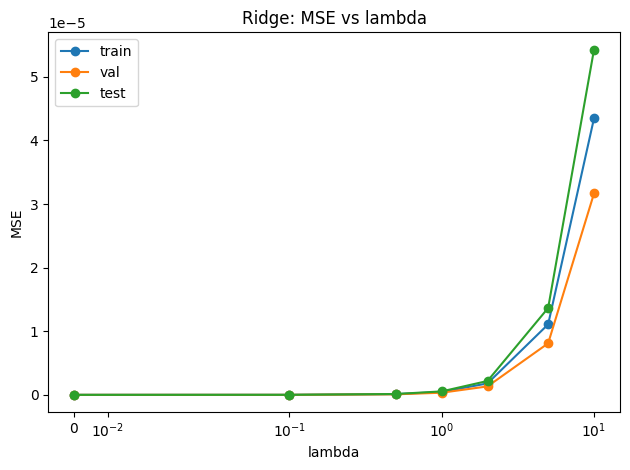

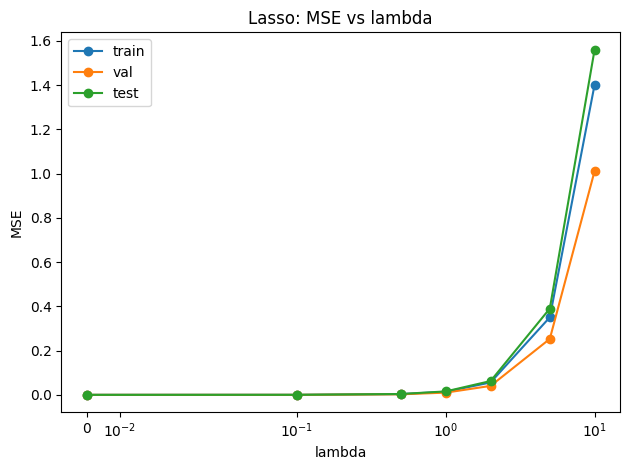

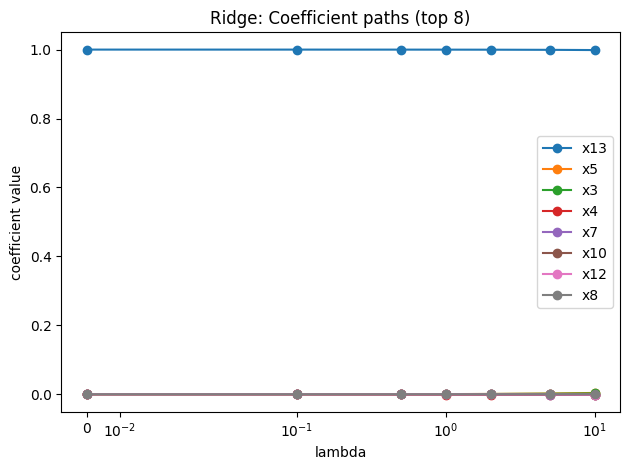

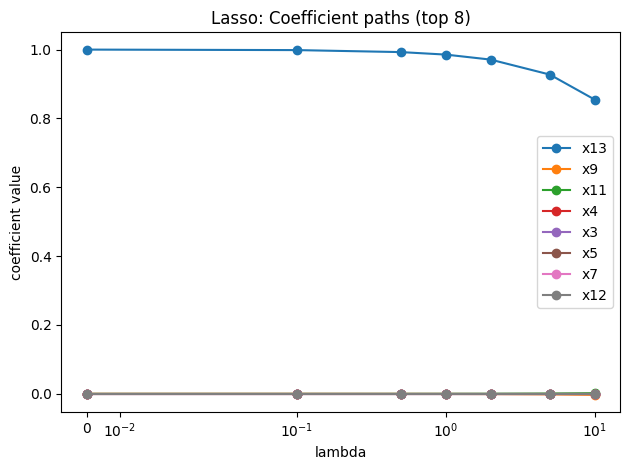

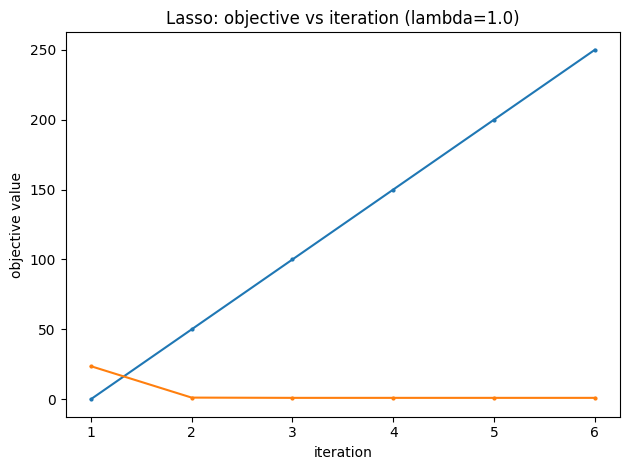

In [154]:
# 1.4 1D. Experiments & Required Plots
# Use λ ∈ {0, 0.1, 0.5, 1, 2, 5, 10}. Report for each λ:
# • Train/val/test MSE
# • R2 on test set
import matplotlib.pyplot as plt

def mse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean((y_true - y_pred) ** 2))

def r2_score(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    ss_res = np.sum((y_true - y_pred) ** 2) #residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) #total sum of sqaures
    return float(1.0 - ss_res / ss_tot) if ss_tot != 0 else 0.0

def run_experiments(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    feature_names=None,
    lambdas=(0, 0.1, 0.5, 1, 2, 5, 10),
    lasso_max_iterations=5000,
    lasso_convergence_tolerance=1e-6
):
    if feature_names is None:
        feature_names = [f"x{i}" for i in range(X_train.shape[1])]

    #hold metric results per lambda
    ridge_rows = []
    lasso_rows = []

    ridge_coefs = []   # list of coef vectors aligned with lambdas
    lasso_coefs = []
    lasso_obj_hist_by_lambda = {}

    for lam in lambdas:
        #Ridge
        if lam == 0:
            ridge_model = OLS_Pinv(fit_intercept=True) #when λ = 0, ridge becomes ordinary least squares, so they use OLS_Pinv.
        else:
            ridge_model = RidgeClosedForm(alpha=lam, fit_intercept=True)

        ridge_model.fit(X_train, y_train)
        ytr = ridge_model.predict(X_train)
        yva = ridge_model.predict(X_val)
        yte = ridge_model.predict(X_test)

        ridge_rows.append({
            "lambda": lam,
            "train_mse": mse(y_train, ytr),
            "val_mse": mse(y_val, yva),
            "test_mse": mse(y_test, yte),
            "test_r2": r2_score(y_test, yte),
        })

        # store ridge weights (exclude intercept for paths)
        if hasattr(ridge_model, "coef_"): #check if there is coef_ attribute
            beta = ridge_model.coef_
            if beta.shape[0] == X_train.shape[1] + 1:  # has intercept
                ridge_coefs.append(beta[1:].copy()) #If length is d+1, it assumes the first is intercept and drops it for plotting paths.
            else:
                ridge_coefs.append(beta.copy())
        else:
            ridge_coefs.append(np.zeros(X_train.shape[1]))

        # ----- Lasso -----
        if lam == 0:
            # treat λ=0 as OLS baseline for clean comparison
            lasso_model = OLS_Pinv(fit_intercept=True)
            lasso_model.fit(X_train, y_train)
            ytr = lasso_model.predict(X_train)
            yva = lasso_model.predict(X_val)
            yte = lasso_model.predict(X_test)

            lasso_rows.append({
                "lambda": lam,
                "train_mse": mse(y_train, ytr),
                "val_mse": mse(y_val, yva),
                "test_mse": mse(y_test, yte),
                "test_r2": r2_score(y_test, yte),
            })

            beta = lasso_model.coef_
            lasso_coefs.append(beta[1:].copy())
            lasso_obj_hist_by_lambda[lam] = None  # no CD run
        else:
            lasso_model = LassoCoordinateDescent(
                alpha=lam,
                fit_intercept=True,
                max_iterations=lasso_max_iterations,
                convergence_tolerance=lasso_convergence_tolerance,
            )
            lasso_model.fit(X_train, y_train)

            ytr = lasso_model.predict(X_train)
            yva = lasso_model.predict(X_val)
            yte = lasso_model.predict(X_test)

            lasso_rows.append({
                "lambda": lam,
                "train_mse": mse(y_train, ytr),
                "val_mse": mse(y_val, yva),
                "test_mse": mse(y_test, yte),
                "test_r2": r2_score(y_test, yte),
            })

            lasso_coefs.append(lasso_model.coef_.copy())
            lasso_obj_hist_by_lambda[lam] = lasso_model.objective_history_

    ridge_coefs = np.vstack(ridge_coefs)  # shape (len(lambdas), d)
    lasso_coefs = np.vstack(lasso_coefs)

    return ridge_rows, lasso_rows, ridge_coefs, lasso_coefs, lasso_obj_hist_by_lambda, list(lambdas), feature_names

def print_report(rows, title):
    print("\n" + "="*70)
    print(title)
    print(f"{'lambda':>8} | {'train_mse':>12} | {'val_mse':>12} | {'test_mse':>12} | {'test_r2':>9}")
    print("-"*70)
    for r in rows:
        print(f"{r['lambda']:>8} | {r['train_mse']:>12.6f} | {r['val_mse']:>12.6f} | {r['test_mse']:>12.6f} | {r['test_r2']:>9.6f}")




# Required plots:
# • Train/val/test MSE vs λ (Ridge and Lasso)
# • Coefficient paths vs λ (at least top 8 coefficients)
# • For Lasso: objective value vs iteration (convergence plot)
        
def plot_mse_vs_lambda(ridge_rows, lasso_rows, lambdas):
    lam = np.array(lambdas, dtype=float)

    def extract(rows, key):
        return np.array([r[key] for r in rows], dtype=float)

    # Ridge
    plt.figure()
    plt.plot(lam, extract(ridge_rows, "train_mse"), marker="o", label="train")
    plt.plot(lam, extract(ridge_rows, "val_mse"), marker="o", label="val")
    plt.plot(lam, extract(ridge_rows, "test_mse"), marker="o", label="test")
    plt.xscale("symlog", linthresh=0.05)  # handles 0 nicely
    plt.xlabel("lambda")
    plt.ylabel("MSE")
    plt.title("Ridge: MSE vs lambda")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Lasso
    plt.figure()
    plt.plot(lam, extract(lasso_rows, "train_mse"), marker="o", label="train")
    plt.plot(lam, extract(lasso_rows, "val_mse"), marker="o", label="val")
    plt.plot(lam, extract(lasso_rows, "test_mse"), marker="o", label="test")
    plt.xscale("symlog", linthresh=0.05)
    plt.xlabel("lambda")
    plt.ylabel("MSE")
    plt.title("Lasso: MSE vs lambda")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_coef_paths(coefs, lambdas, feature_names, model_name, top_k=8):
    lam = np.array(lambdas, dtype=float)
    # pick top-k by max |coef| across lambdas
    importance = np.max(np.abs(coefs), axis=0)
    top_idx = np.argsort(-importance)[:top_k]

    plt.figure()
    for j in top_idx:
        plt.plot(lam, coefs[:, j], marker="o", label=feature_names[j])
    plt.xscale("symlog", linthresh=0.05)
    plt.xlabel("lambda")
    plt.ylabel("coefficient value")
    plt.title(f"{model_name}: Coefficient paths (top {top_k})")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_lasso_convergence(lasso_obj_hist_by_lambda, lam_to_plot=1.0):
    hist = lasso_obj_hist_by_lambda.get(lam_to_plot, None)
    if hist is None:
        print(f"No coordinate descent objective recorded for lambda={lam_to_plot}. (lambda=0 uses OLS baseline.)")
        return

    plt.figure()
    plt.plot(np.arange(1, len(hist) + 1), hist, marker="o", markersize=2)
    plt.xlabel("iteration")
    plt.ylabel("objective value")
    plt.title(f"Lasso: objective vs iteration (lambda={lam_to_plot})")
    plt.tight_layout()
    plt.show()


# After your preprocessing + scaling:
# X_train, y_train, X_val, y_val, X_test, y_test
# feature_names = list_of_feature_names_from_dataframe_columns

lambdas = [0, 0.1, 0.5, 1, 2, 5, 10]
target_col = "MEDV"
y_train = train_df[target_col].values
y_val = validation_df[target_col].values
y_test = test_df[target_col].values

ridge_rows, lasso_rows, ridge_coefs, lasso_coefs, lasso_obj_hist, lam_list, feat_names = run_experiments(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    feature_names=None,
    lasso_max_iterations=5000,
    lasso_convergence_tolerance=1e-6
)

print_report(ridge_rows, "RIDGE results (lambda=0 treated as OLS)")
print_report(lasso_rows, "LASSO results (lambda=0 treated as OLS baseline)")

plot_mse_vs_lambda(ridge_rows, lasso_rows, lam_list)
plot_coef_paths(ridge_coefs, lam_list, feat_names, model_name="Ridge", top_k=8)
plot_coef_paths(lasso_coefs, lam_list, feat_names, model_name="Lasso", top_k=8)

# Convergence plot (choose one lambda > 0)
plot_lasso_convergence(lasso_obj_hist, lam_to_plot=1.0)



In [ ]:
# 1.5 1E. Comparison & Mismatch Analysis
# Compare your fitted parameters and metrics with standard APIs.
